In [65]:
import torch, pickle, sys
sys.path.append('/home/dgotzens/scripts')
import pdfdefaults as pdf
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
from math import sin,cos,sqrt,log10
pi = 3.141592653589 
maxdist = 50
c0 = 299_792_458 
f0, f1 = 76_009_996_288.0, 80_289_505_280.0
omega0, omega1 = 2*pi*f0, 2*pi*f1

t_chirp = 0.000_064_890_002_249_740_060
fs = 22e6
Ts=1/fs

omegadot = (omega1-omega0)/t_chirp

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry,vx,vy = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY'], params['vxPosX'], params['vxPosY']

M=1022
K=len(tx)
ula_idx = torch.full((max(vx)+1,max(vy)+1), -1)
for k, (x,y) in enumerate(zip(vx,vy)):
    if ula_idx[x,y] == -1:
        ula_idx[x,y] = k

def calc_image(data, weights, settings):
    # range FFT
    N, window = settings['N_range'], settings['range_window']
    range_fft = torch.fft.fftshift(torch.fft.fft(window[:,None]*data, N, 0),0)
    range_fft /= window.sum()
    # apply calibration
    range_fft /= weights        

    
    if not settings['enable_elevation']:
        N, window = settings['N_azm'], settings['azm_window']
        ula = settings['ula_idx'][:,0]
        azimuth_fft = torch.fft.fftshift(torch.fft.fft(window*range_fft[:,ula],N,1))
        return azimuth_fft
    
    # reshape into ULA
    idx = settings['ula_idx']
    padded_shape = (settings['N_range'], *idx.shape)
    fft_padded = torch.zeros(padded_shape, dtype=torch.cfloat)

    for m in range(idx.shape[0]):
        for n in range(idx.shape[1]):
            if idx[m,n] >= 0:
                fft_padded[:,m,n] = range_fft[:,idx[m,n]]
    
    # azimuth FFT
    N, window = settings['N_azm'], settings['azm_window']
    azimuth_fft = torch.fft.fft(window[None,:,None]*fft_padded,N,1)
    azimuth_fft /= window.sum()

    # deconvolve
    gaps = idx>=0
    gaps_fft = torch.fft.fft(window[:,None]*gaps, N, 0)
    azimuth_fft /= (gaps_fft+1) # +1 to avoid divergence
    # elevation FFT
    N, window = settings['N_elv'], settings['elv_window']
    elevation_fft = torch.fft.fft(window*azimuth_fft, N, 2)
    elevation_fft /= window.sum()
    
    return elevation_fft

def r_est(R, theta0, K=192):
    # 3xK
    txpos = torch.tensor([tx,ty,[0]*K])
    rxpos = torch.tensor([rx,ry,[0]*K])
    # 3x1xR
    reflpos = R[None,None,:]*torch.tensor([-sin(-theta0), 0, cos(-theta0)])[:,None,None]
    # 3xKx1 - 3x1xR = 3xKxR -> KxR
    return 0.5*torch.sqrt(((txpos[:,:,None]-reflpos)**2).sum(0))\
          + 0.5*torch.sqrt(((rxpos[:,:,None]-reflpos)**2).sum(0))

dBr = lambda x: 20*(x/x.abs().max()).log10()


In [185]:
dist = torch.tensor([.3,.5,1,2,5,10,15,25,40])
D=len(dist)
tau = 2*r_est(dist,-0/180*pi)[None,:,:]/c0

data = torch.exp(1j * omegadot * tau * torch.arange(0,M)[:,None,None]*Ts - 1j*omega0*tau)

settings = {
    'N_range': 1024,
    'N_azm':512,
    'N_elv': 8,
    'range_window': torch.hann_window(M),
    'azm_window': torch.hann_window(max(vx)+1),
    'elv_window': torch.hann_window(max(vy)+1),
    'ula_idx': ula_idx,
    'enable_elevation': False
    }

N = settings['N_azm']
weights = torch.ones(K)
m_refl = (settings['N_range'] * dist/maxdist).int()
angle = -180/pi*torch.asin(2*torch.arange(N)/N-1)
pdf.setup()
plt.figure()
for d in range(D):
    img = calc_image(data[:,:,d], weights, settings)[m_refl[d],:]
    plt.plot(angle, dBr(img.abs()), linewidth=0.1+d*0.2, label=f'{dist[d]:.1f}m')
plt.legend(ncols=3)
plt.xlim(-20,20)
plt.gcf().set_figheight(0.7*pdf.a4_textwidth)
plt.gca().xaxis.set_major_formatter(EngFormatter('°'))
plt.gca().yaxis.set_major_formatter(EngFormatter('dBr'))
plt.grid()
plt.savefig('/home/dgotzens/thesis/figures/fft_doa_peak.pdf')
plt.show()

/tmp/ipykernel_3733864/3057014530.py:34: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [161]:
lambda0 = c0/f0
aperture = 86*lambda0/2
df = 2*aperture**2 / lambda0

print(f'{round(1000*lambda0,3)=}mm, {round(100*aperture,3)=}cm, {round(df,3)=}m')

round(1000*lambda0,3)=3.944mm, round(100*aperture,3)=16.96cm, round(df,3)=14.585m


In [50]:
sigma = sqrt(0.5)
noise = sqrt(sigma)*torch.randn((M,K), dtype=torch.cfloat)
dist = torch.tensor([30])
# dist = torch.linspace(1,30,3)
tau = 2*r_est(dist,-0/180*pi)[None,:,:]/c0
data = torch.exp(-1j * omegadot * tau * torch.arange(0,M)[:,None,None]*Ts - 1j*omega0*tau)

settings = {
    'N_range': 1024,
    'N_azm':512,
    'N_elv': 8,
    'range_window': torch.hann_window(M),
    'azm_window': torch.hann_window(max(vx)+1),
    'elv_window': torch.hann_window(max(vy)+1),
    'ula_idx': ula_idx,
    'enable_elevation': False
    }

weights = torch.ones(K)

# for n, d in enumerate(dist):
#     plt.plot(data.real[10,ula_idx[:,0],n])
#     plt.title(f'{d:.1f}m')
#     plt.show()

mean_Ps=27.210, mean_Pn=0.000, 10*log10(mean_Ps/mean_Pn)=infdB


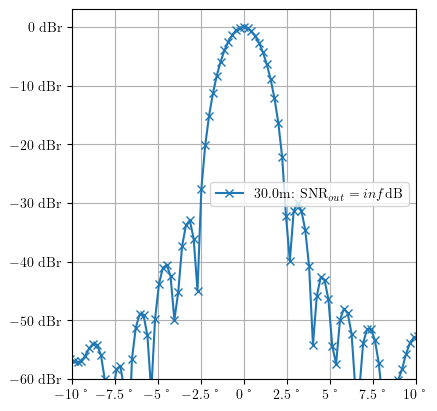

In [53]:
#pdf.setup()
%matplotlib inline
plt.figure()
N = settings['N_azm']
angle = -180/pi*torch.asin(2*torch.arange(N)/N-1)
for n, (d,style) in enumerate(zip(dist,('x-','-','--'))):
    mean_img = torch.zeros(N)
    mean_Pn = 0
    m_refl = int(round(float(settings['N_range'] * d/maxdist)))

    iterations = 1000
    img_signal = calc_image(data[:,:,n].conj(), weights, settings).abs()[m_refl,:]
    mean_Ps = img_signal.square().mean()

    # for i in range(iterations):
    #     noise = sqrt(sigma)*torch.randn((M,K), dtype=torch.cfloat)
    #     img_noise = calc_image(data, weights, settings).abs()[m_refl,:]
    #     mean_Pn += img_noise.square().mean()/iterations
    plt.plot(angle, dBr(img_signal), style, label=f'{d:.1f}m: SNR$_{{out}}={10*log10(mean_Ps/mean_Pn):.1f}$dB')
    print(f'{mean_Ps=:.3f}, {mean_Pn=:.3f}, {10*log10(mean_Ps/mean_Pn)=:.3f}dB')
plt.ylim(-60,3)
plt.xlim(-10,10)
ax=plt.gca()
ax.xaxis.set_major_formatter(EngFormatter('°'))
ax.yaxis.set_major_formatter(EngFormatter('dBr'))
plt.grid()
# plt.title(f'Intensity in Azimuth\nSNR={20*log10(1/sigma):.1f}dB')
plt.legend()
plt.gcf().set_figwidth(0.7*pdf.a4_textwidth)
plt.show()
#plt.savefig('/home/dgotzens/thesis/figures/fft_doa_accuracy.pdf')
